# Scale Out Demo: K-means (CPU-to-GPU-to-MNMG)

### Motivation
How can a data scientist streamline the path from a proof-of-concept to a fully distributed product feature?

It is a great feeling when you demonstrate an interesting new capability that impresses your leadership so much, they want to fast track it into production.  It is a not-so-great feeling when you realize how much work is needed to transform your early-stage prototype into customer-ready software at a global scale.

RAPIDS helps position your software to scale out quickly, with minimal code changes, even for multi-node, multi-GPU (MNMG) deployments.  RAPIDS does this by aligning its APIs with those of standard, CPU-based Python libraries.  RAPIDS enables both the productivity you expect from Python and the performance you need for global scale.

In general, consider scaling out technologies when your data is too big to fit on a single GPU or when you need to simultaneously analyze data that is spread across multiple files.

### This Notebook
This notebook is intended to:
1. Introduce scaling out with RAPIDS and Dask.
2. Introduce how Dask works "under the hood."
3. Show how to modify code to leverage RAPIDS and Dask.

This notebook is *not* intended to:
1. Address complexities from real-world data.
2. Help with algorithm-level improvements.

Key items to note:
1. Adopting RAPIDS typically involves only changing import statements and occasional syntax differences.
    * RAPIDS strives to maintain the same API as other Python libraries.
    * You won't have to refactor a lot of function signatures.
2. Scaling out with Dask requires additional code on both CPUs and GPUs.

### Technology overview
pandas is a Python library for data manipulation and analysis on CPUs.

cuDF is a Python GPU DataFrame library that provides a Pandas-like API.  cuDF is built on the Apache Arrow in-memory columnar format, which is fast and enables transfers between different systems.

Dask is a Python library for parallel computing.  Dask is a core technology for scaling out software.  The Dask API is largely consistent with locally-run Python libraries (pandas, numpy, scikit-learn), which makes getting up to speed realtively easy.  The partitions of a Dask DataFrame are each pandas DataFrames.

Dask-cuDF is the Python GPU DataFrame library used for running distributed on Dask.

For distributed algorithms, the API requires a different input format than the locally run algorithms.  Dask's API requires a Dask DataFrame or Array as input.  cuML's API for distributed algorithms is very similar to the Dask DataFrame API.  The difference is that the underlying data frames are cuDF, not Pandas.  Dask cuPy arrays are also available.

For more information, see:

* pandas: https://pandas.pydata.org/
* RAPIDS: https://github.com/rapidsai | https://docs.rapids.ai/ | https://medium.com/rapids-ai
* cuDF documentation:  https://docs.rapids.ai/api/cudf/stable
* Dask: https://dask.org/
* Dask-cuDF: https://github.com/rapidsai/dask-cudf

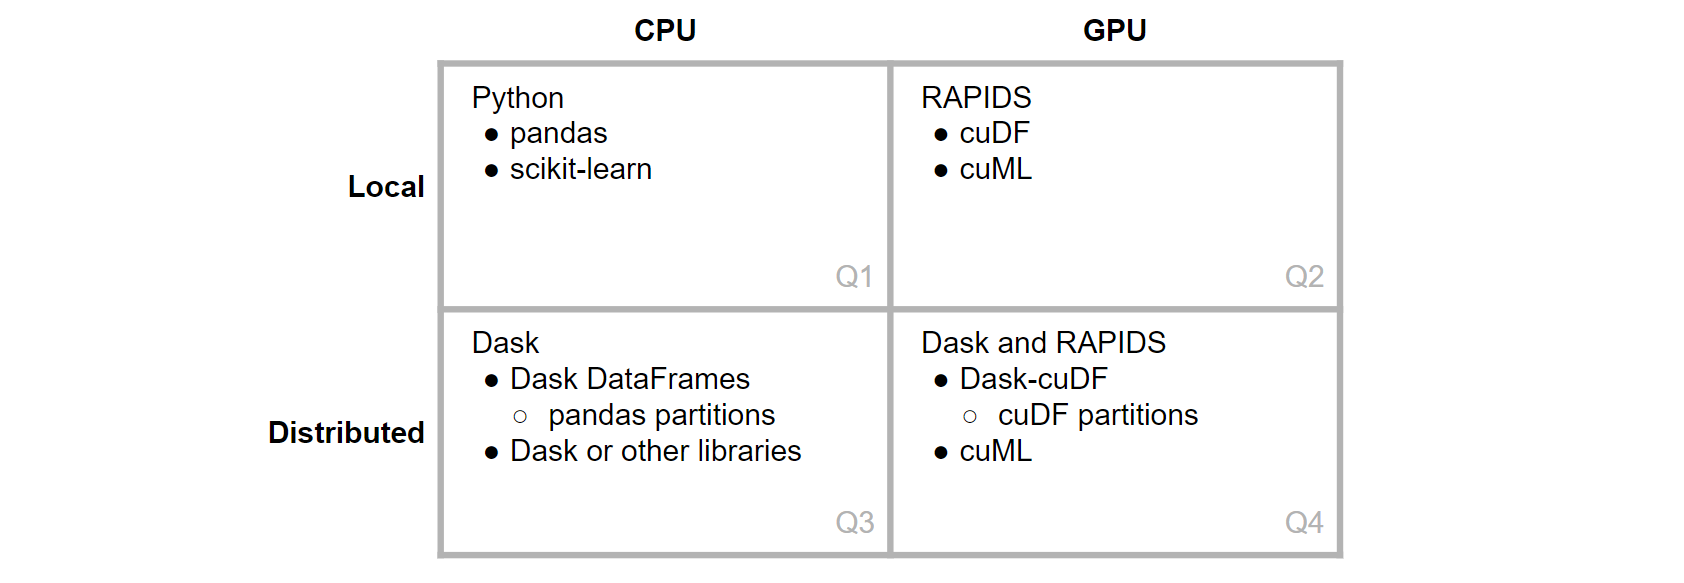
> The choice of technologies to use depends on the hardware you intend to use.


### K-means

K-means is a basic yet powerful clustering method optimized via Expectation Maximization.  It randomly selects K data points in X and computes which samples are close to these points.  For every cluster of points, a mean is computed, and this becomes the new centroid.

For CPU architectures, a k-means implementation is available in Scikit-learn for local computation and in Dask for distributed computation.

For GPU architectures, a k-means implementation is available in cuML, which can be run on a single GPU or distributed in a multi-node multi-GPU (MNMG) fashion.

cuML's k-means supports the scalable KMeans++ initialization method, which is more stable than randomly selecting k points.

cuML models can take input as array-like objects, either in host (CPU) as NumPy arrays or in device (GPU) as Numba or cuda_array_interface-compliant arrays, as well as cuDF data frames.

For more information, see:

* cuML's k-means implementation:  https://docs.rapids.ai/api/cuml/stable/api.html#cuml.KMeans

## Imports

In [ ]:
import pandas as pd
import cudf

# Data generation
from cuml.datasets import make_blobs

# Local compute
from sklearn.cluster import KMeans as cpuKMeans
from cuml.cluster import KMeans as gpuKMeans

# Distributed compute
import dask_cudf
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
from dask_ml.cluster import KMeans as daskKMeans
from cuml.dask.cluster.kmeans import KMeans as mnmgKMeans

# Comparing results
import cupy
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

try:
    import matplotlib.pyplot as plt
except ImportError:
    print('Installing matplotlib.')
    !conda install -q -c conda-forge -y matplotlib
    import matplotlib.pyplot as plt

# Enable drawing images in this notebook.  No need to for interactive graphics.
%matplotlib inline

## Generate data
This dataset is for illustration purposes only.

In [ ]:
# Generate a dataset
n_samples = 100000
n_features = 2
n_clusters = 6
random_state = 0
cluster_std = 0.1

input_data, input_labels = make_blobs(n_samples=n_samples,
                                      n_features=n_features,
                                      centers=n_clusters,
                                      random_state=random_state,
                                      cluster_std=cluster_std)

# Save the data for CPU compute
data_cpu = pd.DataFrame(input_data)
labels_cpu = pd.Series(input_labels.get())

# Save the data for GPU compute
data_gpu = cudf.DataFrame(input_data)
#labels_gpu = cudf.Series(input_labels) # TODO can this be removed?

# Plot the raw data and labels
fig = plt.figure(figsize=(16,10))
plt.scatter(data_cpu.iloc[:,0], data_cpu.iloc[:,1], c=labels_cpu, s=50, cmap='viridis')

## Local compute

### CPU model (Host)

In [ ]:
# Instantiate the algorithm
kmeans_cpu = cpuKMeans(init="k-means++",
                       n_clusters=n_clusters,
                       random_state=random_state)

# Train and run the algorithm
kmeans_cpu.fit(data_cpu)
labels_cpu = kmeans_cpu.predict(data_cpu)

### GPU model (Device)

In [ ]:
# Instantiate the algorithm
kmeans_gpu = gpuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       random_state=random_state)

# Train and run the algorithm
kmeans_gpu.fit(data_gpu)
labels_gpu = kmeans_gpu.predict(data_gpu)

## Scale out (distributed) compute

### Distributed setup and implementation
The additional steps required to scale out your code using Dask are in setting up Dask and in implementing your code to be compatible with Dask's execution paradigm.

Setting up Dask requires instantiating a cluster and a Client.
* The Dask cluster has a distributed scheduler and a number of workers.
    * We'll use the default schedulers.
    * Typically the number of workers equals the number of available computing resources.
* A Client points to the Dask cluster.
    * Instantiating the Client will make code run on the Dask cluster it points to.

Note: Using Dask on a single computer does not require any setup.  Dask will distribute computation using the computer's thread pool.

Unlike the local CPU and GPU implementations, Dask implementation is a two-step process.
1. Create the Dask task graph.
    * This step is largely aligned to non-Dask Python APIs.
    * All Dask methods prior to the next step create the Dask task graph.
2. Execute the Dask task graph.
    * Do this by calling <font color=red>`compute`</font> on the Dask DataFrame.

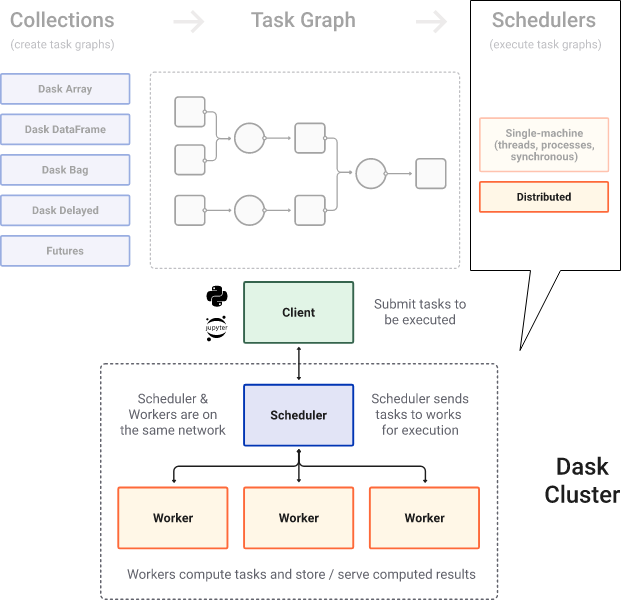
> High level collections are used to generate task graphs which can be executed on a single machine or a cluster. Using the Distributed scheduler enables creation of a Dask cluster for multi-machine computation.
(image from: https://docs.dask.org/en/latest/how-to/deploy-dask-clusters.html)

### Scale out CPU model
Scikit-learn does not have an equivalent distributed implementation, but Dask does.

In order to get the result from any Dask object, you need to call compute.  This computes several Dask collections at once.

In [4]:
# Setup the distributed CPU Dask cluster
client_dask = Client()

# TODO Check https://blog.dask.org/2020/07/30/beginners-config

# Examine the Dask status
print('CPU Dask cluster')
print('ncores per worker node: ' + str(client_dask.ncores()))

# Setup the Dask task graph

# Instantiate the algorithm
kmeans_dask = daskKMeans(init="k-means||",
                         n_clusters=n_clusters,
                         n_jobs=-1,
                         random_state=random_state)

# Train the algorithm
kmeans_dask.fit(data_cpu)

# Run the algorithm and save the output for later analysis
kmeans_dask_df = kmeans_dask.predict(data_cpu)

# Execute the Dask task graph
labels_dask = kmeans_dask_df.compute()

client_dask.close()  # Close the CPU Dask client

# TODO display the output

### Scale out MNMG model

In [ ]:
# Setup the MNMG Dask cluster
cluster_mnmg = LocalCUDACluster()
client_mnmg = Client(cluster_mnmg)

print('GPU Dask cluster')
print('ncores per worker node: ' + str(client_mnmg.ncores()))

In [ ]:
# Convert data into Dask-cuDF format for distributed compute.

# To minimize memory consumption, ensure that each Dask worker has exactly one partition.
npartitions = 2  # TODO set this equal to the client GPU ncores

# Setup the Dask task graph
data_mnmg = dask_cudf.from_cudf(data_gpu, npartitions=npartitions)

# Execute the Dask task graph
data_mnmg.compute() 

print('MNMG data transform complete.')

In [5]:
# Setup the Dask task graph

# Instantiate the algorithm
kmeans_mnmg = mnmgKMeans(init="k-means||",
                         n_clusters=n_clusters,
                         random_state=random_state)

# Train and run the algorithm and save the output
kmeans_mnmg.fit(data_mnmg)
kmeans_mnmg_df = kmeans_mnmg.predict(data_mnmg)

# Execute the Dask task graph
labels_mnmg = kmeans_mnmg_df.compute()

print('MNMG k-means labels:')
print(labels_mnmg)

# NOTE: Keep the MNMG cluster open for analysis below.


## Analysis

### Dask diagnostics
TODO Show the cluster map instead of the task graphs?? Or "performance_report"? (see https://docs.dask.org/en/stable/diagnostics-distributed.html)



### Visualization
Scikit-learn's k-means implementation uses the k-means++ initialization strategy while cuML's k-means uses k-means||. As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in make_blobs is increased.

Note: Visualizing the centroids will only work when n_features = 2.

In [ ]:
fig = plt.figure(figsize=(16,10))
plt.scatter(data_cpu.iloc[:,0], data_cpu.iloc[:,1], c=labels_cpu, s=5, alpha=0.005, cmap='viridis')

# Plot the CPU centers
centers_cpu = kmeans_cpu.cluster_centers_
plt.scatter(centers_cpu[:,0], centers_cpu[:,1], c='blue', s=100, alpha=0.5)

# Plot the GPU centers
centers_gpu = kmeans_gpu.cluster_centers_
plt.scatter(cupy.asnumpy(centers_gpu[0].values), cupy.asnumpy(centers_gpu[1].values), facecolors='none', edgecolors='red', s=100)

# Plot the Dask centers
centers_dask = kmeans_dask.cluster_centers_
plt.scatter(centers_dask[:,0], centers_dask[:,1], marker='s', facecolors='none', edgecolors='blue', s=250)

# Plot the MNMG centers
centers_mnmg = kmeans_mnmg.cluster_centers_
plt.scatter(cupy.asnumpy(centers_mnmg[0].values), cupy.asnumpy(centers_mnmg[1].values), marker='s', facecolors='none', edgecolors='red', s=400)

plt.title('CPU, GPU and distributed k-means clustering')
plt.show()

### Results comparison

In [ ]:
# Use the CPU labels as "truth"
# Local
score_cpu = adjusted_rand_score(labels_cpu, kmeans_cpu.labels_)
score_gpu = adjusted_rand_score(labels_cpu, kmeans_gpu.labels_.to_array())

threshold = 1e-4
passed = abs(score_cpu - score_gpu) < threshold
print('Local CPU and GPU k-means results are ' + ('equal' if passed else 'NOT equal') + '.')

# Distributed
score_dask = adjusted_rand_score(labels_cpu, kmeans_dask.labels_)
score_mnmg = adjusted_rand_score(labels_cpu, labels_mnmg.to_array())

passed = abs(score_dask - score_mnmg) < threshold
print('Distributed CPU and GPU k-means results are ' + ('equal' if passed else 'NOT equal') + '.')


## Conclusion
RAPIDS makes it easy to position your code to scale out from a single GPU to multi-node, multi-GPU (MNMG) distributions. Because RAPIDS APIs largely match standard Python libraries, the step from local CPU to local GPU is minimal. The step to MNMG only requires setting up the Dask cluster.

Using RAPIDS from the beginning of your project could save you a lot of time and effort when it comes time to take your code to the next level.

Need to work with SQL?  Check out dask-sql: https://dask-sql.readthedocs.io/en/latest/

## Backup
<font color=red>TODO Put sample outputs of plots, Dask task graphs, etc. here, in case we encounter runtime problems. </font>

### The Task Graph
The motivation to vizualize the Dask task graph is purely to help get a sense for how Dask works behind the scense.  You probably will never have to look at a Dask task graph unless you are developing new Dask modules.

Dask represent programs as graphs.  The nodes are units of computation (e.g. function calls), and the edges are data dependencies.  The task scheduler executes the graph, leveraging parallelism when possible.

TODO http://distributed.dask.org/en/stable/journey.html
TODO https://docs.dask.org/en/stable/graphs.html

<font color=red>TODO compare what happens with a smaller number of nodes with more GPUs vs. a larger number of nodes with fewer GPUs.</font>

In [ ]:
# For visualizing the Dask task graph
try:
    import graphviz
except:
    print('Installing python-graphviz')
    !conda install -q -c conda-forge -y graphviz
    !conda install -q -c conda-forge -y python-graphviz
    import graphviz

In [ ]:
# Draw CPU Dask task graph
kmeans_dask_df.visualize()

In [ ]:
# Draw GPU Dask task graph
kmeans_mnmg_df.visualize()

In [ ]:
# Print CPU Dask task graph (text)
kmeans_dask_df.dask

In [ ]:
# Print GPU Dask graph (text)
kmeans_mnmg_df.dask